In [76]:
import pandas as pd
import numpy as np
import optuna

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import itertools
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm 
%matplotlib inline

import joblib
from datetime import datetime

In [77]:
max_jobs_count = -1

In [78]:
X_train = pd.read_excel("C:\\\\Users\\kosma\\OneDrive\\Рабочий стол\\git_projects\\tweet_appeal\\ml_models\\dataset\\X_train.xlsx", index_col=0)["text"]
X_test = pd.read_excel("C:\\Users\\kosma\\OneDrive\\Рабочий стол\\git_projects\\tweet_appeal\\ml_models\\dataset\\X_test.xlsx", index_col=0)["text"]
y_train = pd.read_excel("C:\\Users\\kosma\\OneDrive\\Рабочий стол\\git_projects\\tweet_appeal\\ml_models\\dataset\\y_train.xlsx", index_col=0)
y_test = pd.read_excel("C:\\Users\\kosma\\OneDrive\\Рабочий стол\\git_projects\\tweet_appeal\\ml_models\\dataset\\y_test.xlsx", index_col=0)

In [79]:
tf_idf_vect = TfidfVectorizer(lowercase = False).fit(X_train)

# train
X_train = tf_idf_vect.transform(X_train)
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

# test
X_test = tf_idf_vect.transform(X_test)
y_test = le.transform(y_test)

c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [80]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues, filename=None):
    """
    This function prints and plots the confusion matrix.

    Normalization can be applied by setting 'normalize=True'
    """
    plt.clf()
    plt.cla()
    plt.close()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout(pad=1.8)
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.grid(False)
    if filename is None:
        
        fig = plt.gcf()
        fig.set_size_inches(20, 15)
    else:
        fig = plt.gcf()
        fig.set_size_inches(int(f_size*0.6), int(f_size*0.6))
        #plt.savefig(filename)     

In [81]:
def make_classification(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)
    return classifier

In [82]:
def print_report(name, classifier, X_test, y_test, average_name, class_names):
    y_pred = classifier.predict(X_test)
    y_pred = y_pred.tolist()
    
    print(name)
    print(f1_score(y_test, y_pred, average=average_name))
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(precision_recall_fscore_support(y_test, y_pred, average=average_name))

    # Не нормированная матрица:
    cur_confusion_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cur_confusion_matrix, [str(_) for _ in range(1)], f_size=12, title='Матрица ошибок', filename='matrix.png')
    
    # Нормированная матрица (округление до 3 знаков):
    mat = confusion_matrix(y_test, y_pred, normalize='true')
    mat = pd.DataFrame(mat, index=np.unique(y_test), columns=np.unique(y_test))
    mat = mat.apply(lambda x: round(x, 3))
    f, ax = plt.subplots(figsize=(7, 7))
    sns_plot = sns.heatmap(mat, annot=True, cbar=False, cmap="Blues")
    
    # Нормированная матрица (округление до 2 знаков):
    mat = mat.apply(lambda x: round(x, 2))
    f, ax = plt.subplots(figsize=(7, 7))
    sns_plot = sns.heatmap(mat, annot=True, cbar=False, cmap="Blues")
    

In [83]:
sp = KFold()

def get_optuna_clf(clf, param_val_dict, X_train, y_train, f1_type, n_jobs=-1):
    """
    Нахождение классификатора с оптимальным значинем параметров 
    @param clf: классификатор
    @param f1_type: тип f1, "macro" или "weighted" 
    @param param_val_dict: словарь с набором значений парамтеров для перебора
    return opt_serach - результаты OPTUNA
    """
    if n_jobs:
        opt_search = optuna.integration.OptunaSearchCV(clf, param_val_dict, n_jobs=n_jobs, cv=5, scoring=f1_type, n_trials=100, timeout=10000) 
    else:
        opt_search = optuna.integration.OptunaSearchCV(clf, param_val_dict, cv=5, scoring=f1_type, n_trials=100, timeout=10000) 
    opt_search.fit(X_train, y_train)
    return opt_search

In [84]:
#param_distr = {'C': optuna.distributions.IntUniformDistribution(1,100),
#               'solver': optuna.distributions.CategoricalDistribution(choices=('newton-cg', 'lbfgs','liblinear','sag','saga'))}
param_distr = {'C': optuna.distributions.FloatDistribution(1,100),
               'solver': optuna.distributions.CategoricalDistribution(choices=('newton-cg', 'lbfgs','liblinear','sag','saga'))}

In [85]:
t1 = datetime.now()
clf = LogisticRegression(random_state=42, 
                         class_weight='balanced', 
                         penalty='l2', 
                         tol=1e-06, 
                         n_jobs=max_jobs_count)
#f1-weighted
opt_search = get_optuna_clf(clf, param_distr, X_train, y_train, 'f1_macro') 

C:\Users\kosma\AppData\Local\Temp\ipykernel_9732\56612342.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_search = optuna.integration.OptunaSearchCV(clf, param_val_dict, n_jobs=n_jobs, cv=5, scoring=f1_type, n_trials=100, timeout=10000)
[I 2024-08-03 22:36:52,845] A new study created in memory with name: no-name-6fd3245f-6732-4e1c-87fc-c3648d599f2d
c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
c:\Users\kosma\OneDrive\Рабочий стол\git_projects\tweet_appeal\.ve

In [86]:
print(f'LogisticRegression fit time = {(datetime.now() - t1).seconds} sec')

LogisticRegression fit time = 28 sec


{'C': 8.126759328547369, 'solver': 'sag'}
0.780349405145523
LogisticRegression(C=8.126759328547369, class_weight='balanced', n_jobs=-1,
                   random_state=42, solver='sag', tol=1e-06)
LogisticRegression, f1_macro
0.7794960461299467
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1303
           1       0.74      0.76      0.75       981

    accuracy                           0.78      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.78      0.78      0.78      2284

(0.7788284362549801, 0.7803285447289756, 0.7794960461299467, None)


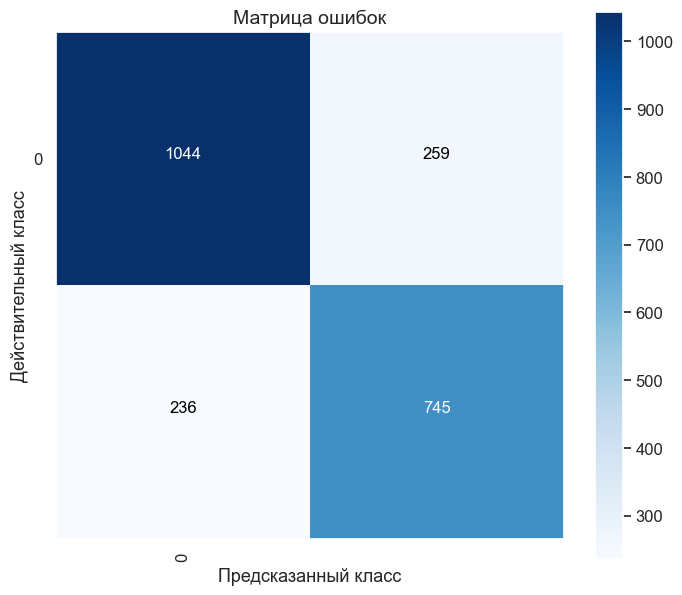

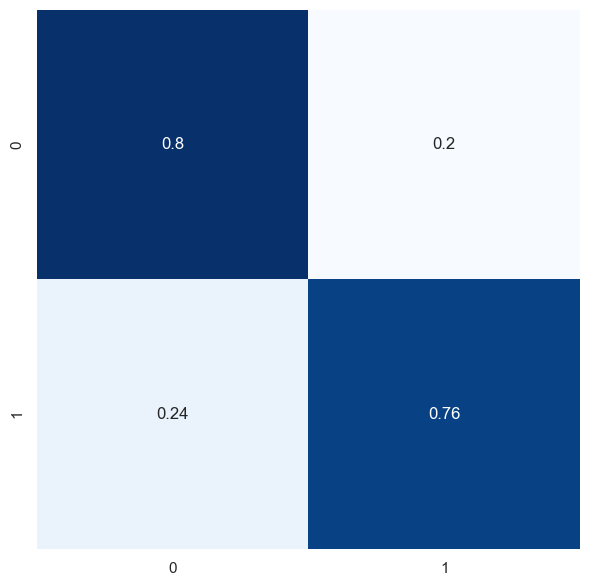

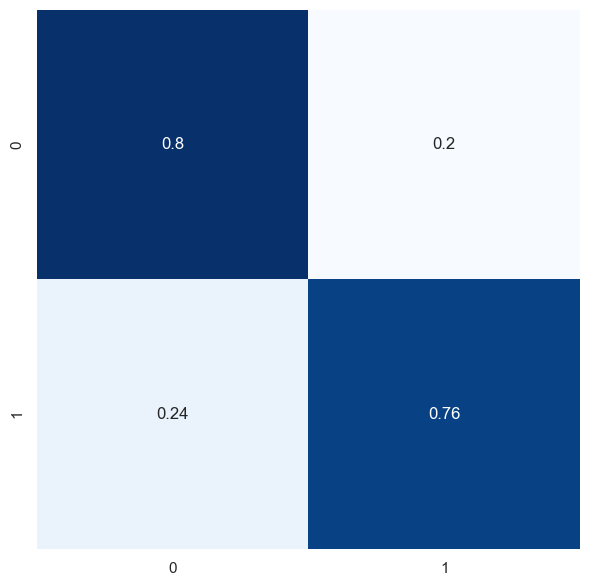

In [87]:
print(opt_search.best_params_)
print(opt_search.best_score_)
print(opt_search.best_estimator_)
class_names = ["0", "1"]
print_report('LogisticRegression, f1_macro', opt_search.best_estimator_, X_test, y_test, 'macro',class_names)

In [88]:
joblib.dump(opt_search.best_estimator_, 'LogisticRegression_f1_macro.pkl')

['LogisticRegression_f1_macro.pkl']